# Introduction

The purpose of this project is to develop a relatively simple way to access US Census Current Population Survey (CPS) data, with the aim of identifying drivers of wage levels in the US. This project will only focus on a small Generalized Linear Model (GLM); namely, the relationship between wage levels, the level of education and gender but the class below can also handle more complex models. Firstly, the methodology used to access and analyse the data will be outlined. The results of the analysis will then be discussed. Finally, a brief summary of the finding will be provided and ideas for future analysis discussed.  

---

# Methodology

## Import relevant packages

In [1]:
conda install -c conda-forge statsmodels

Solving environment: ...working... done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from dateutil.relativedelta import relativedelta
from matplotlib.ticker import FormatStrFormatter, StrMethodFormatter
import statsmodels.api as sm
import statsmodels.stats.api as sms
from patsy import dmatrices

In [3]:
%config Completer.use_jedi = False

## Class Development

The class 'CPSAnalysis'is designed to allow quick access and analysis of the Current Population Survey (CPS) data. The class includes (as a default) a number variables; however, the variables can be changed, if required. The class also includes multiple methods that allow the user to plot a histogram and boxplot, fit a model, analyse the residuals of the model and show predictions.

In [22]:
#Class development

class CPSAnalysis:
    
    """
    Description: Developed for inital analysis of the US Current Population Survey dataset. This class allows the user
    to analyse the data using a histogram and boxplots. Furthermore, a generalized linear model approach can be used to determine possible drivers
    for a given dependent variable.
    
    All available variables are described in the data dictionary: https://www2.census.gov/programs-surveys/cps/datasets/2021/basic/2021_Basic_CPS_Public_Use_Record_Layout_plus_IO_Code_list.txt
    
    
        Attributes
        -----------
    data: pandas DataFrame
        Dataset containing the data to be modelled.
    variables: list
        Displays the initial variables passed as arguments in the __init__() method.
    
        Methods
        -------
    print_init_vars()
        lists the inital variables used to obtain the dataset from the US CPS website.
        
    hist(x)
        Uses matplotlib plot and seaborn to plot a histogram for a given variable x.
    
    box(x, y)
        Uses matplotlib plot and seaborn to plot a boxplot for a given variable x
        against a given variable y.
        
    mod_fit(model, fam_link=default stats model)
        Uses statsmodels & patsy (dmatrices) to fit a GLM and return the results.  
            
    
    """
    def __init__(self, start_mth, start_year, no_months ,vars=['PTERNHLY', 'PRTAGE', 'PESEX', 'PTDTRACE', 
                                        'PEEDUCA','PRCOWPG', 'PRMJIND1', 'PRMJOCC1','GEREG']):
        """
        Parameters
        ----------
        start_mth: int
            The month to start from when importing the data from the CPS website
        start_year: int
            The year to start from when importing the data from the CPS website
        no_months: int
            The number of months to include when importing the data from the CPS website 
        vars: list
            The columns to include when importing the data from the CPS website. 
            The default vars are included as a keyword argument.
        
        """
        self.start_date = dt.date(start_year, start_mth, 1)
        self.no_months = no_months
        self.date_range = [(self.start_date + relativedelta(months=month)).isoformat() for month in range(self.no_months)]
        self.variables = [v.lower() for v in vars]
        self.get_data()
        self.clean_data(vars)
    
    def __str__(self):
        return ('The initial variables available to examine are ' + str(self.variables))
    
    
    #data prep methods
    def get_data(self):
        
        self.data_list = []
        #for loop here
        for date in self.date_range:
            self.my_date = dt.datetime.strptime(date,'%Y-%m-%d')
            self.year = str(self.my_date.year)
            self.yr = self.year[-2:]
            self.mth = self.my_date.strftime('%b').lower()
            
            self.doc = self.mth + self.yr + 'pub.csv'
      
            self.data_set = pd.read_csv('https://www2.census.gov/programs-surveys/cps/datasets/'+ self.year + '/basic/' + self.doc, 
                         usecols=self.variables, low_memory=False)[self.variables] 
            self.data_list.append(self.data_set)
        
        #concat dfs here
        self.data_i = pd.concat(self.data_list)    
        self.data_i.reset_index(drop=True, inplace=True)
        
        return self.data_i
    #Clean data
    def clean_data(self, vars):
        self.data = self.data_i.applymap(lambda x: self.negative_cleanup(x)).copy()
        self.data.dropna(axis=0,inplace=True)
        self.data.reset_index(drop=True, inplace=True)
        
        default_vars = ['PTERNHLY', 'PRTAGE', 'PESEX', 'PTDTRACE','PEEDUCA', 'PRCOWPG', 'PRMJIND1', 'PRMJOCC1','GEREG']
           
        if vars == default_vars:
              
            #Only run if default vars are used
            new_cols = {
                self.data.columns[0]: 'Hourly Earnings',
                self.data.columns[1]: 'Age',
                self.data.columns[2]: 'Gender',
                self.data.columns[3]: 'Race',
                self.data.columns[4]: 'Education',
                self.data.columns[5]: 'Class of Worker',
                self.data.columns[6]: 'Industry',
                self.data.columns[7]: 'Occupation',
                self.data.columns[8]: 'Region'   
            }

            #rename columns
            self.data.rename(columns = new_cols, inplace = True)

            #Adjust decimal places in earnings columns

            self.data['Hourly Earnings'] = self.data['Hourly Earnings'].map(lambda x: x/100).round(2)
            
            # Make values more descriptive
            
            #Group age variable
            bins = [0, 20, 30, 40, 50, 60, 110]
            labels = ['Under 20', '20-29', '30-39', '40-49', '50-59', '60 and over']
            self.data['Age'] = pd.cut(self.data['Age'], bins=bins, labels=labels, right=False)
            
           
            #change sex values
            sex_dict = {1.0: 'Male', 2.0: 'Female'}
            self.data['Gender'] = self.data['Gender'].map(sex_dict)
            #change race values
            self.data['Race'] = np.where(self.data.Race == 1.0, 'White Only',
                                     np.where(self.data.Race == 2.0, 'Black Only', 
                                        np.where(self.data.Race == 3.0, 'American Native Only',
                                            np.where(self.data.Race == 4.0, 'Asian Only', 
                                                 np.where(self.data.Race == 5.0, 'Hawaiian Only',
                                                    np.where((self.data.Race >= 6.0) & (self.data.Race <= 15.0), 'Two Race Combo', 'Three+ Race Combo'))))))

            #Change education values
            self.data['Education'] = np.where(self.data.Education < 37.0, '10th Grade Education',
                                     np.where((self.data.Education >= 37.0) & (self.data.Education <= 39.0), 'High School Education', 
                                        np.where((self.data.Education >= 40.0) & (self.data.Education <=42.0), 'College Education',
                                            np.where(self.data.Education == 43.0, 'Bachelor Degree', 'Post Graduate or Higher'))))


            #Change class of worker values
            cow_dict = {1.0: 'Private', 2.0: 'Government'}
            self.data['Class of Worker'] = self.data['Class of Worker'].map(cow_dict)

            #Change major industry values
            ind_dict = {1.0: 'Agriculture, forestry, fishing, and hunting', 2.0: 'Mining', 3.0: 'Construction',
                       4.0: 'Manufacturing', 5.0: 'Wholesale and retail trade', 6.0: 'Transportation and utilities',
                       7.0: 'Information', 8.0: 'Financial activities', 9.0: 'Professional and business services',
                       10.0: 'Educational and health services', 11.0: 'Leisure and hospitality', 12.0: 'Other services',
                       13.0: 'Public administration', 14.0: 'Armed Forces'}
            self.data['Industry'] = self.data['Industry'].map(ind_dict)

            #Change major occ values
            occ_dict = {1.0: 'Management, business, and financial occupations', 2.0: 'Professional and related occupations',
                        3.0: 'Service occupations', 4.0: 'Sales and related occupations', 5.0: 'Office and administrative support occupations',
                        6.0: 'Farming, fishing, and forestry occupations', 7.0: 'Construction and extraction occupations',
                        8.0: 'Installation, maintenance, and repair occupations', 9.0: 'Production occupations',
                        10.0: 'Transportation and material moving occupations', 11.0: 'Armed Forces'}
            self.data['Occupation'] = self.data['Occupation'].map(occ_dict)

            #Change region values
            reg_dict = {1.0:'Northeast', 2.0: 'Midwest', 3.0: 'South', 4.0: 'West'}
            self.data['Region'] = self.data['Region'].map(reg_dict)
            
            return self.data
        
        else:  
            return self.data
        
    def negative_cleanup(self, value):
        
        if value < 1:
            value=np.nan
            return (value)
        else:
            return (value)
       
########################################### methods accessible by user#####################################
    #list the initial variables passed when the object was instantiated
    def print_init_vars(self):
        
        for i in self.variables:
            print(i)
                         
    
    #Create histogrma to analyse the dependent variable
    def hist(self, x):
        """
        Plot a histogram for a given variable.
        
        Parameters
        ----------
        x: str
            The name of the variable to plot.
            
        """
        
        plt.figure(figsize=(22, 18))
        sns.set_theme(style="ticks", palette="pastel")
        sns.set(font_scale=3.0)
        
        sns.histplot(data=self.data, x= x, kde=True, log_scale=False)
       
    #Create box plots for selected variables   
    def box(self, x, y):
        """
        Uses matplotlib plot and seaborn to plot a boxplot.
        
        Parameters
        ----------
        x: str
            Independent variable to plot on x axis
        y: str
            Dependent variable to plot on x axis
        """

        form = '{x:.2f}'
        
        #check dtype for cat or cont variables
        plt.figure(figsize=(22, 18))
        sns.set_theme(style="ticks", palette="pastel")
        sns.set(font_scale=3.0)
        
        my_order = self.data.groupby(by=[x])[y].mean().sort_values().index
        
        ax = sns.boxplot(x= x , y= y, data=self.data, order=my_order)
        ax.yaxis.set_major_formatter(StrMethodFormatter(form))
        plt.xticks(rotation=90)
        plt.title(y + ' vs ' + x) 
        plt.ylabel(y)
        plt.xlabel(x)    

    #Fitting the model
    def mod_fit(self, model, fam_link = sm.families.Poisson(link=sm.families.links.log())):
        
        """
        Uses statsmodels & patsy (dmatrices) to fit a GLM and return the results.  
        
        Parameters
        ----------
        model: str
            Describe the model to fit in dmatrices format
        fam_link: statsmodels function (optional):
            Default is set to Poisson with a log link function.
            
        """
        
        
        y, X = dmatrices(model, data=self.data, return_type='dataframe')
        mod = sm.GLM(y, X, fam_link)
        self.result = mod.fit() 
        
        return self.result

    #Resdiuals
    def residuals(self):
        
        """
        Uses the model results, matplotlib plot and seaborn to plot 
        the pearson residual against the fitted values. 
        
        """
        
        fit = self.result.fittedvalues
        fit.name = 'y_hat'

        err = self.result.resid_pearson
        err.name = 'residuals'

        #df = self.data.filter([y, x], axis=1)

        diag_data = pd.concat([fit, err], axis =1)
        diag_data['y_hat'] = diag_data['y_hat'].round(2)

        #Plotting the residuals
        plt.figure(figsize=(22, 18))
        form = '{x:.2f}'
        sns.set_theme(style="ticks", palette="pastel")
        sns.set(font_scale=3.0)

        ax = sns.stripplot(x='y_hat', y='residuals', data=diag_data,jitter =0.35)
        ax.yaxis.set_major_formatter(StrMethodFormatter(form))
        ax.axhline(0.00, c='red', ls='--', lw=2.5)
        plt.xticks(rotation=90)
        plt.title('Residuals vs Mean') 
        plt.xlabel('Fitted mean')
        plt.ylabel('Pearson residual')
    
    def pred(self, *args):
        
        """
        Uses the model results to show the expected values and 95% confidence interval estimates
        for each combination of the variables used in the model. Returns a dataframe.
        
        Parameters
        ----------
        *args: str
            Independent variables used in the model
      
        """
        
        
        var_list = [v for v in args]
        df = self.data.filter(var_list, axis=1)
    
        pred = self.result.get_prediction()
    
        pred = pred.summary_frame()
    
        pred_data = pd.concat([pred, df], axis=1)
    
        new_names = {
            pred_data.columns[0]: 'Predicted Hourly Earnings',
            pred_data.columns[1]: 'Mean Standard Error',
            pred_data.columns[2]: 'Lower Confidence Interval (95%)',
            pred_data.columns[3]: 'Upper Confidence Interval (95%)'} 
    
        pred_data.rename(columns = new_names, inplace = True)
    
        pred_data['Predicted Hourly Earnings'] = pred_data['Predicted Hourly Earnings'].round(2)
        pred_data['Lower Confidence Interval (95%)'] = pred_data['Lower Confidence Interval (95%)'].round(2)
        pred_data['Upper Confidence Interval (95%)'] = pred_data['Upper Confidence Interval (95%)'].round(2)
    
        pred_data.drop_duplicates(inplace=True)
        pred_data.sort_values(by='Predicted Hourly Earnings', inplace=True, ignore_index=True)
        
        self.prediction_data = pred_data.copy()
        
        return self.prediction_data
        
        

## Initial analysis: Wage, education level and gender

Use the CPSAnalysis class to instantiate an object 'wagedata' that holds the CPS data from the first three months of 2020.  

In [23]:
wagedata = CPSAnalysis(1, 2020, 3)

Check the columns included in the object

In [10]:
wagedata.data.columns

Index(['Hourly Earnings', 'Age', 'Gender', 'Race', 'Education',
       'Class of Worker', 'Industry', 'Occupation', 'Region'],
      dtype='object')

Plot a histogram of the dependent variable 'Hourly Earning'. The histogram suggests a gamma distribution.

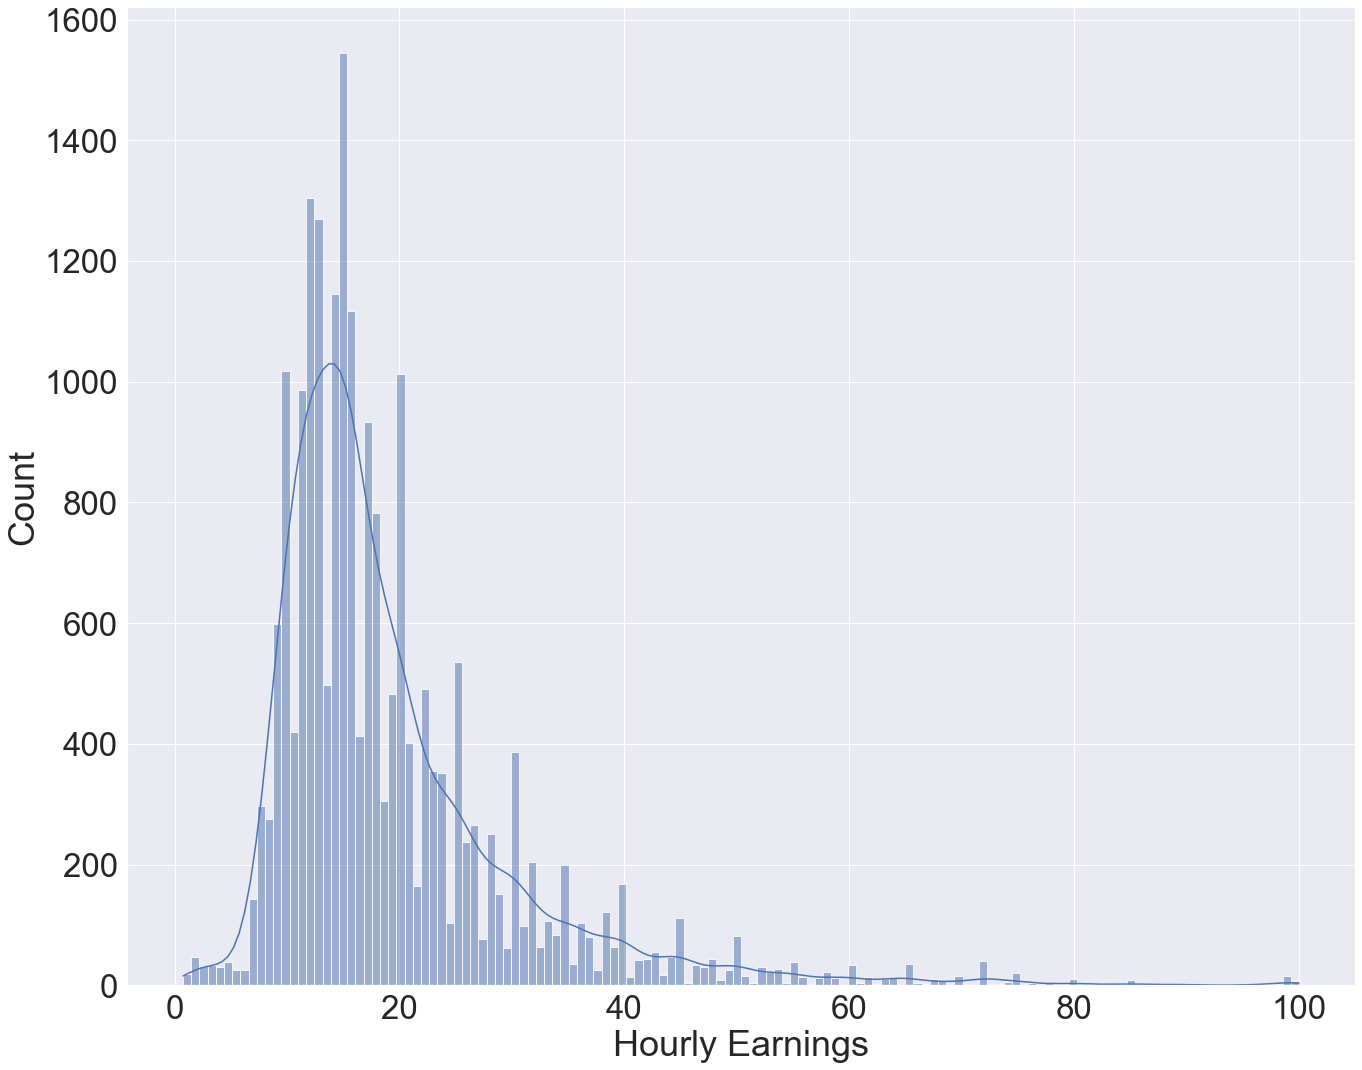

In [26]:
wagedata.hist('Hourly Earnings')

Describe the dependent variable.

In [25]:
wagedata.data['Hourly Earnings'].describe()

count    21029.000000
mean        19.301364
std         11.158623
min          0.750000
25%         12.350000
50%         16.000000
75%         22.480000
max         99.990000
Name: Hourly Earnings, dtype: float64

Examine the first 5 rows of the wagedata dataframe.

In [24]:
wagedata.data.head(5)

,Hourly Earnings,Age,Gender,Race,Education,Class of Worker,Industry,Occupation,Region
0,19.00,20-29,Male,Black Only,College Education,Private,Professional and business services,Production occupations,South
1,16.75,60 and over,Female,White Only,Bachelor Degree,Private,Construction,Office and administrative support occupations,South
2,7.25,60 and over,Female,Black Only,College Education,Private,Educational and health services,Service occupations,Northeast
3,12.00,40-49,Female,Asian Only,High School Education,Private,Wholesale and retail trade,Office and administrative support occupations,Northeast
4,15.00,30-39,Male,Black Only,High School Education,Private,Manufacturing,Production occupations,Northeast


Plot a boxplot of the 'Education' variable against the dependent variable 'Hourly Earnings'. The boxplot suggests the mean hourly earnings increase with the level of education. Therefore, education is probably a good variable to include in the GLMs model.

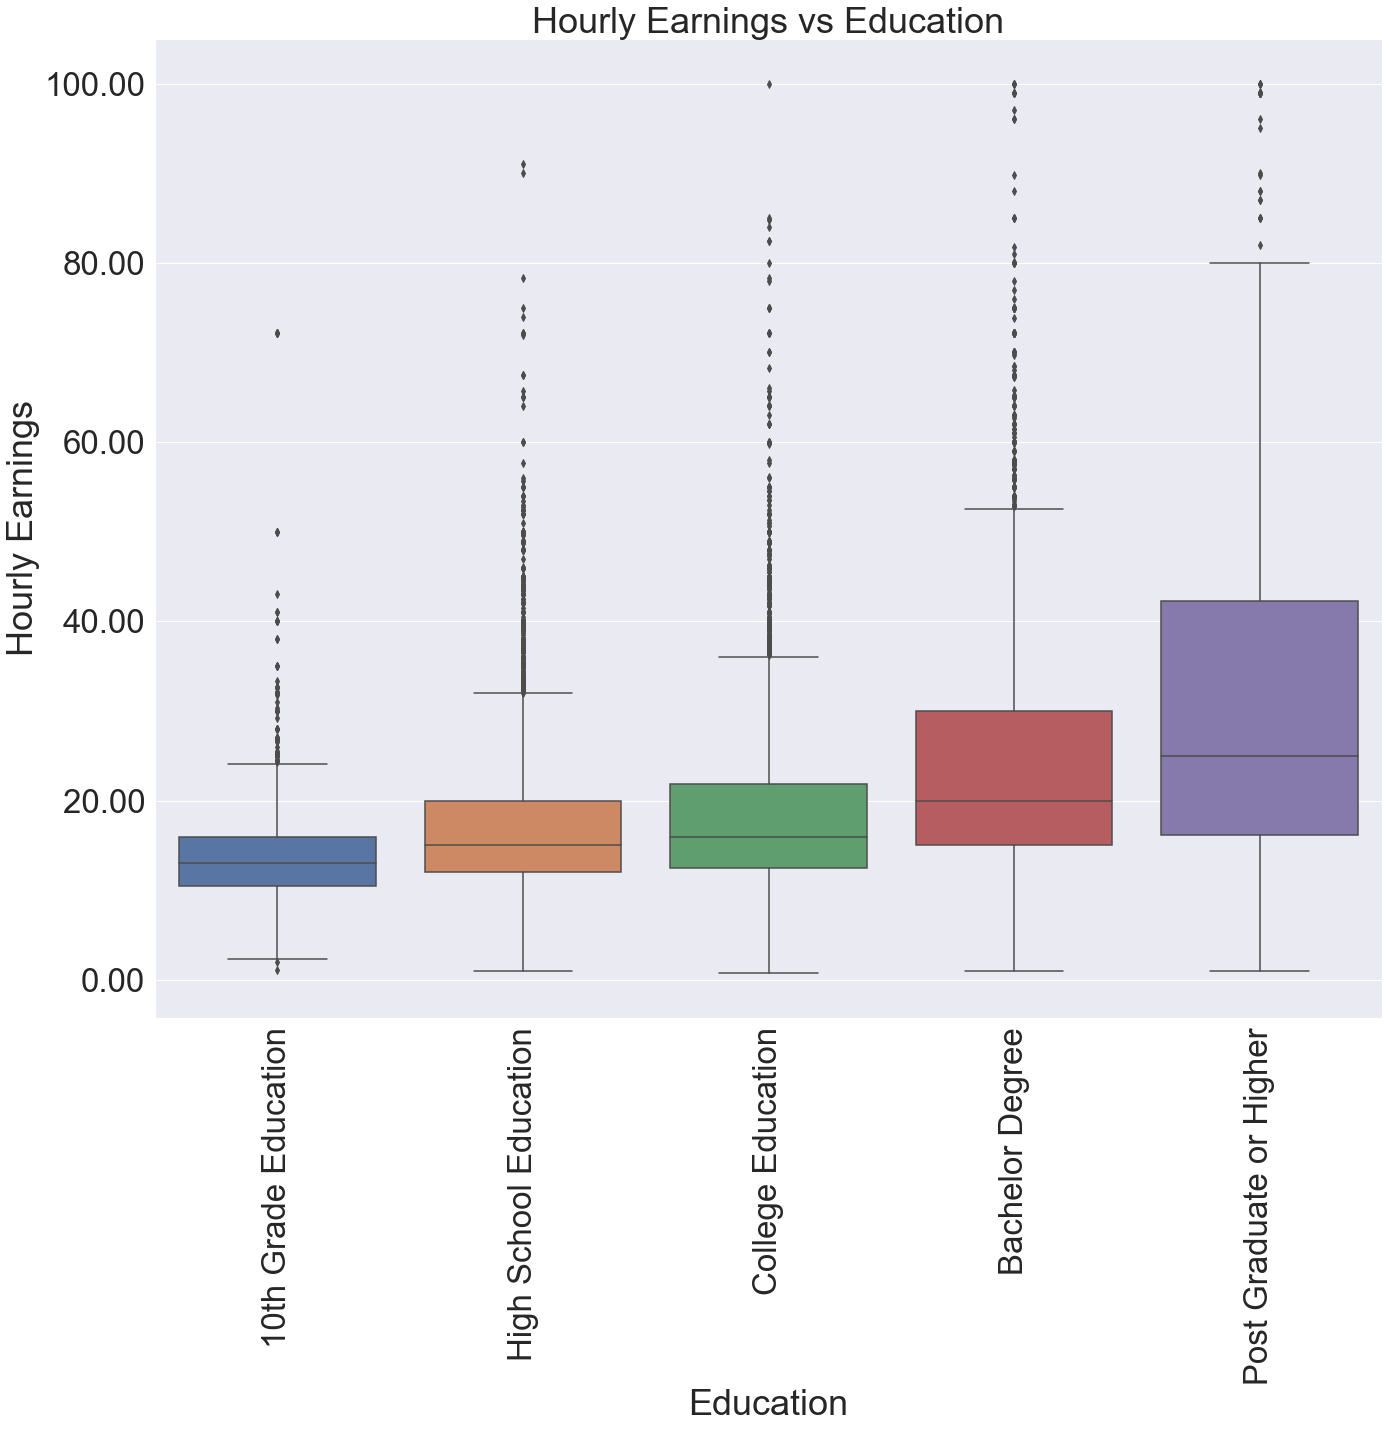

In [27]:
wagedata.box('Education', 'Hourly Earnings')

Plot a boxplot of the 'Gender' variable against the dependent variable 'Hourly Earnings'. The boxplot suggests the mean hourly earnings are higher for men. Therefore, gender is probably a good variable to include in the GLMs model.

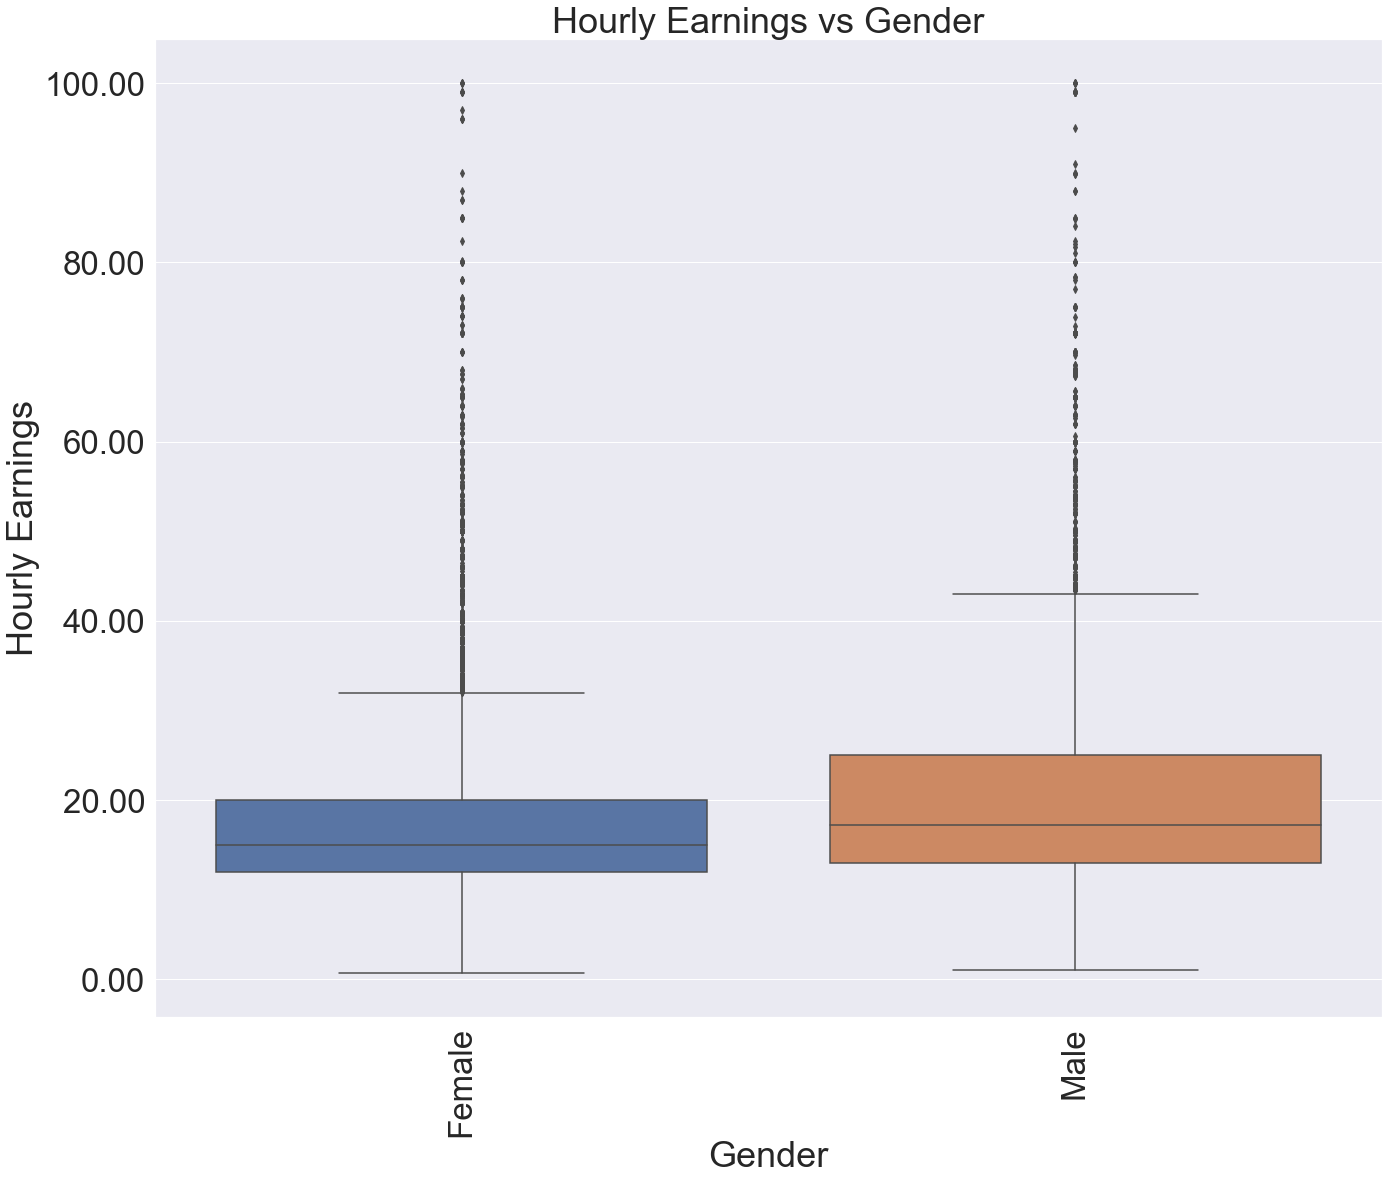

In [28]:
wagedata.box('Gender', 'Hourly Earnings')

## Building and fitting the model

The model is fitted by calling the fit_mod() method available in the CPSAnalysis class. This model has been developed to determine if an individual's hourly earning is dependent upon their level of education and gender. Since education and gender are categorical variables, 10th Grade Education and female has been set as references using the Treament method. Therefore, the intercept refers to the expected hourly earnings for females with a 10th grade education.

In [29]:
my_result = wagedata.mod_fit("Q('Hourly Earnings') ~ C(Education, Treatment(reference='10th Grade Education')) + C(Gender, Treatment(reference='Female'))",
                            fam_link = sm.families.Gamma(link=sm.families.links.log()))

---

# Results

The result shown below indicate that all the coefficients for the education and gender categories are statistical significant (p-values all very low) in that they are higher than the reference (female with a 10th grade education). The expected hourly earnings are higher for females with higher levels of education and this increases for males at evey level.

In [30]:
print(my_result.summary())

                  Generalized Linear Model Regression Results                   
Dep. Variable:     Q('Hourly Earnings')   No. Observations:                21029
Model:                              GLM   Df Residuals:                    21023
Model Family:                     Gamma   Df Model:                            5
Link Function:                      log   Scale:                         0.24404
Method:                            IRLS   Log-Likelihood:                -73458.
Date:                  Mon, 06 Sep 2021   Deviance:                       4366.1
Time:                          20:03:29   Pearson chi2:                 5.13e+03
No. Iterations:                      10                                         
Covariance Type:              nonrobust                                         
                                                                                           coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------

## Model Diagnostics

In this section, the residuals for a given variable are ploted by calling the method 'residuals()'. The residuals are plotted below. No distinct pattern can be seen in the residuals but there are a lot of positive outliers. 

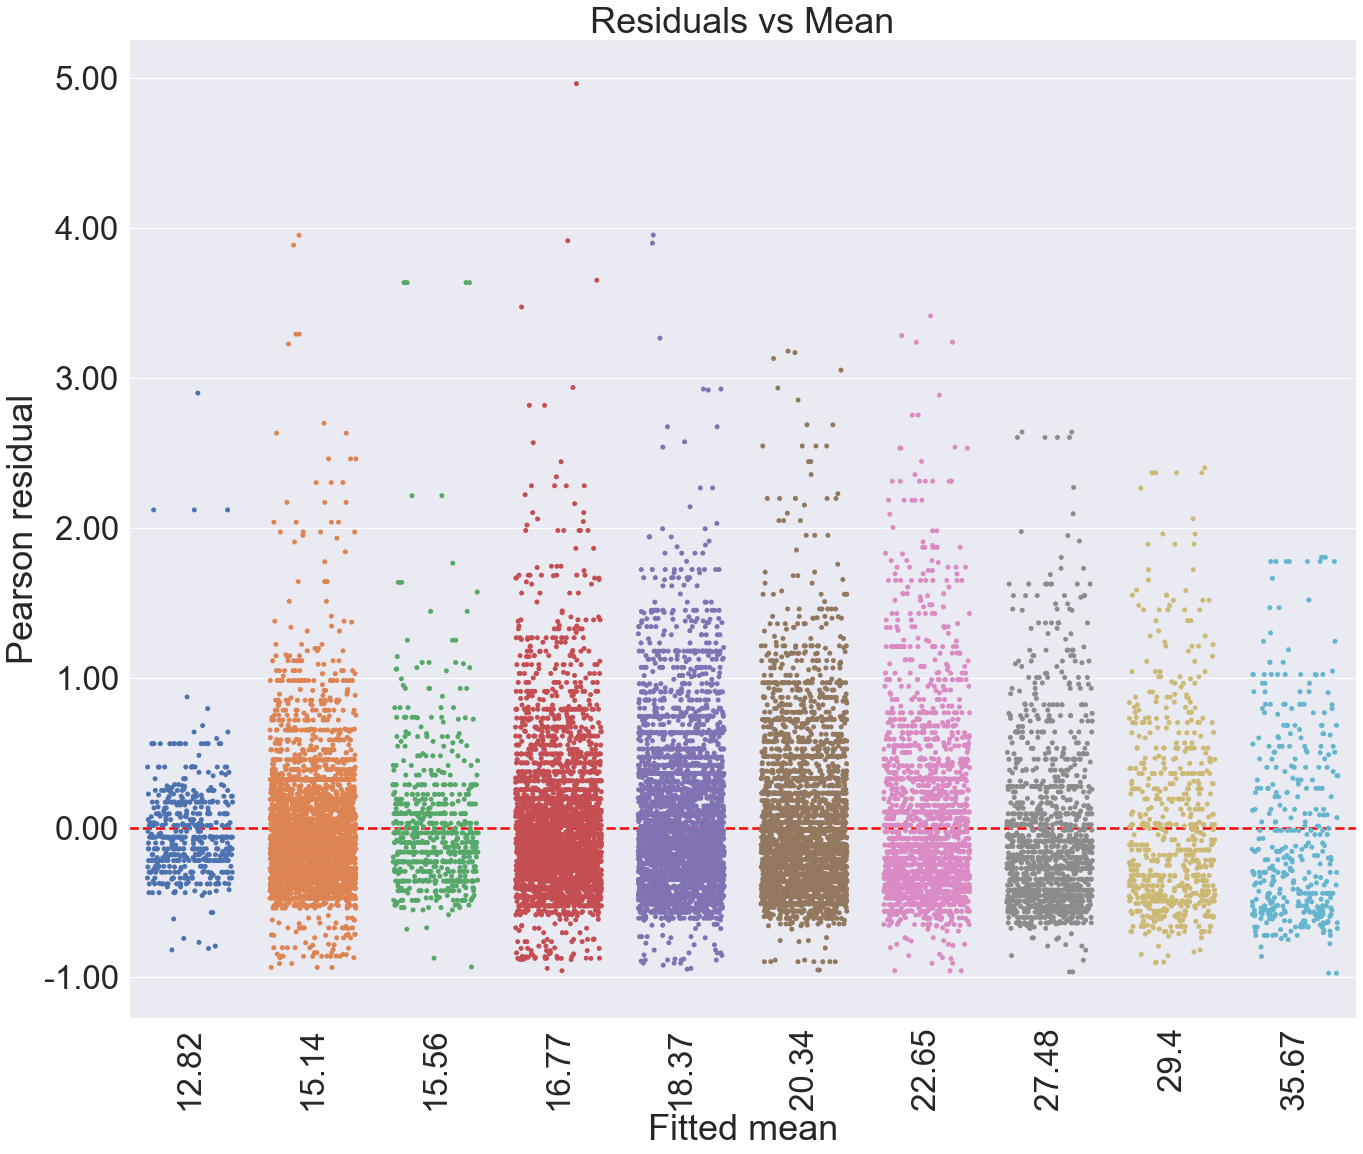

In [31]:
wagedata.residuals()

## Simple prediction using the model

A prediction of the model for each combination of the exogenous can be generated by calling pred(var1, var2,...). This will return a dataframe showing predicated values, standard erros and upper and lower bounds of the 95% confidence interval estimates. The predicted values for the model are shown below. 

In [34]:
wage_prediction = wagedata.pred('Education', 'Gender')
wage_prediction

,Predicted Hourly Earnings,Mean Standard Error,Lower Confidence Interval (95%),Upper Confidence Interval (95%),Education,Gender
0,12.82,0.191078,12.45,13.20,10th Grade Education,Female
1,15.14,0.100917,14.95,15.34,High School Education,Female
2,15.56,0.228428,15.11,16.01,10th Grade Education,Male
3,16.77,0.111280,16.55,16.99,College Education,Female
4,18.37,0.115761,18.14,18.60,High School Education,Male
5,20.34,0.140203,20.07,20.62,College Education,Male
6,22.65,0.199365,22.26,23.04,Bachelor Degree,Female
7,27.48,0.256865,26.98,27.98,Bachelor Degree,Male
8,29.40,0.449622,28.54,30.30,Post Graduate or Higher,Female
9,35.67,0.559213,34.59,36.78,Post Graduate or Higher,Male


In [35]:
wage_prediction.to_csv(r'data\wage_prediction_educ_gender.csv', index=False, header=True)

---

# Conclusion

In conclusion, the model indicates that, on average, education level and gender play a significant role in determining an individual's expected hourly earnings. This is obviously not the full picture and more variables need to be included in the model to determne other key factors related to wage level. Future models could include the other variables included in the class. There may also be one or more interaction variables that need to be considered. For example, *Education X Gender*. More analysis is also required in relation to the fit of the model overall.   

The class code could also be updated to allow for greater flexibility in grouping the categorical variables. Also, other regression methods (such as OLS) could be included in future versions of the code.  